## Coding for Lecture V 

by *Suwichaya Suwanwimolkul, Ph.D.*

The coding exercies and examples are used as parts of  *Lecture V: MLE-KL, Conditional MLE,  MLE-MSE, MLE-MAE, MMSE*  in **Estimation Theory EE2102523**. 

The topics covered in this exercise are: 
- [KL Divergence](#kl-divergence)  
    - [Central Limit Theorem Example](#central-limit-theorem-clt)
- [Variational Auto Encoder](#variational-auto-encoder-vae)
    - [What is it?](#what-is-variational-auto-encoder-vae)
    - [KL Divergence is used in learning](#why-we-need-kl-divergence-loss)
    - [Training](#training-phase)
    - [Testing](#testing-phase)
    - [Impact of KL Divergence](#how-kl-div-loss-impact-the-encoded-features)


Note: Don't forget to do `pip install -r requirements.txt`

References:

1. We use the example of variational auto encoder from [pytorch/examples](https://github.com/pytorch/examples)
2. Also, we obtain most of the content about the kl loss used in training  variational auto encoder from [This Medium Page](https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7) ...


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import os
import joypy

from utils import KL_expo, CTL_simulation

cwd = os.getcwd()  

## KL divergence

We can measure the convergence in distribution using KL divergence... 

\begin{equation}
KL(P||Q) = \sum_{x \in X} P(x) \log(\frac{P(x)}{Q(x)})
\end{equation}
where $P(x)$ denotes the probability of $X=x$ corresponding to the reference and $Q(x)$ denotes the probability of $X=x$ corresponding to the target.  



### Association with Convergence in Distribution

If $\lim_{n \rightarrow \infty} P_{X_n}(x) = Q_{X}(x)$, or  $X_n \xrightarrow{d} X$, then, for $P_{X_n}(x)$ and $Q_{X}(x)$ being the probabilities associated with $X_n$ and $X$, the KL-Divergence between them approach 0: 
\begin{equation}
 X_n \xrightarrow{d} X \hspace{0.5cm}  \Rightarrow  \hspace{0.5cm}	KL(P||Q) = \sum_{x \in \mathcal{X}} P_{X_n}(x) \log{\frac{P_{X_n}(x)}{Q_{X}(x)}}  = 0 
\end{equation} 
 

#### Central Limit Theorem (CLT)

The sum of random samples will converge to a normal distribution random variable as $n \rightarrow \infty$ 
$$ Z_n =   \frac{ \sum_{i=1}^n X_i  - n\mu}{\sigma \sqrt{n}} $$    

The following example shows that 

- CLT of Bernoulli RV converges to a normal distribution; and 

- CLT of Uniform RV converges the same normal distribution.  

- Therefore, the KL divergence between the CTL of Bernoulli and CLT of Uniform to zero ! ... 

We compare the convergence of Bernoulli vs Uniform R.V. towards Normal distribution. 

- To compute $KL(P||Q)$, we will use `np.histogram` to provide $P(x)$ for the reference (normally distributed samples).

- Then, $Q(x)$ will be computed by `np.histogram`whose inputs are the samples that are originally simulated from the Bernoulli/Uniform distribution.

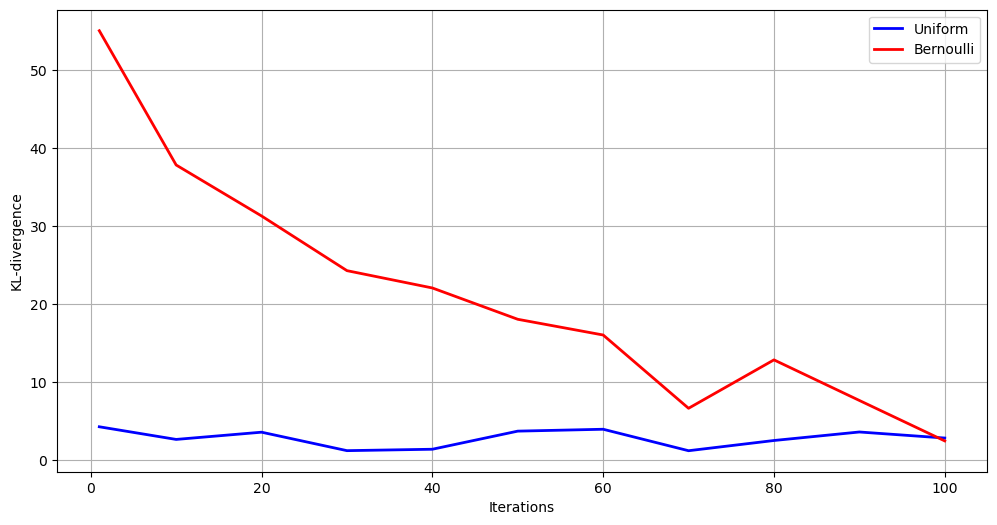

In [2]:
dirpath = os.path.join(cwd, "Ex1-KL-div-between-Uniform-Bernoulli")
os.makedirs(dirpath, exist_ok=True)

N_size = 100
N_list = [1,10,20,30,40,50,60,70,80,90,100]
KL_scores_bernoulli_list = []
KL_scores_uniform_list = []

for N in N_list:
    KL_scores_uniform   = CTL_simulation(N_round=N, N_size= N_size, orginal_distribution="Uniform", dirpath=dirpath, hide_showplots=True)
    KL_scores_bernoulli = CTL_simulation(N_round=N, N_size= N_size, orginal_distribution="Bernoulli", dirpath=dirpath, hide_showplots=True)
    KL_scores_uniform_list.append(KL_scores_uniform)
    KL_scores_bernoulli_list.append(KL_scores_bernoulli)

plt.figure(figsize=(12,6))
plt.plot(N_list, KL_scores_uniform_list, color="blue", linewidth=2, label="Uniform")
plt.plot(N_list, KL_scores_bernoulli_list, color="red", linewidth=2, label="Bernoulli")
plt.ylabel("KL-divergence")
plt.xlabel("Iterations")
plt.grid()
plt.legend()
plt.show()

# Using KL divergence in Variational Auto Encoder  

In [3]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

os.makedirs('results', exist_ok=True)

## What is Variational auto encoder (VAE)?

 

- What is it? It is a DNN with encoder and decoder, which is similar to an autoencoder.  However,  what makes the VAE different is the part that makes it *variational* ....  

- *Variational* means that there are some uncertainty in the latent features to be decoded ...  

    - That is, instead of directly obtaining the encoded latent features into decoding, it will decode the sampled latent features...  

    - The sampled latent feature is the feature that is most likely to happen to be orthogonal and uncorrelated. 
    
    - This can be modelled with a Normal distribution with zero mean and unit variance ! 


- The sampling part is called **reparameterization trick**. That is, the encoded features are used as the mean, and, then it is added with a Gaussian white noise. 


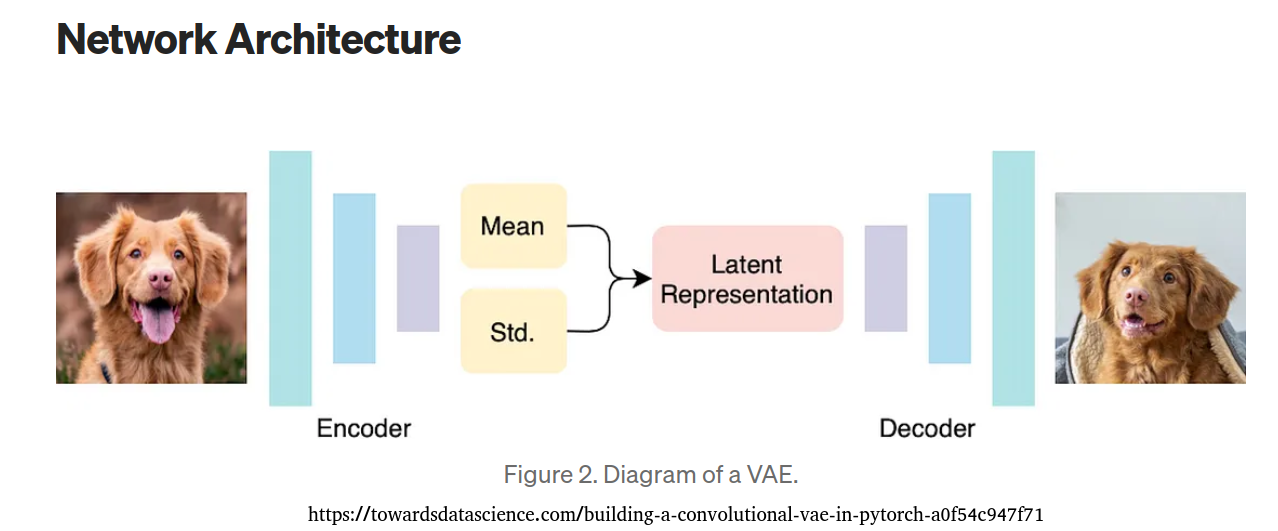

In [4]:
from IPython.display import Image
Image(filename='./Vae.png',width=1200, height=800)
#The picture is from and we recommend reading https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7 ...

### Why we need KL-divergence loss ?

Because we want to learn *mean* and *standard deviation* in the yellow block above, such that they become *zero mean* and *unit variance*. 

This can be done by applying the $KL$-Divergence between two Gaussian distributions:

$$ KL(\mathcal{N}(\mu_1, \sigma_1) || \mathcal{N}(\mu_2, \sigma_2)) = \log{ \frac{\sigma_2}{\sigma_1} } + \frac{\sigma^2_1 (\mu_1 - \mu_2)^2 }{2\sigma^2_2} - \frac{1}{2}  $$

If $\mu_1$ = 0 and $\sigma_1$ = 1, 

$$ KL(\mathcal{N}(\mu_1, \sigma_1) || \mathcal{N}(0, 1)) = \log{ \sigma_2 } + \frac{ \mu_2^2 }{2\sigma^2_2} - \frac{1}{2}  = -\frac{1}{2} (1  - \frac{ \mu_2^2 }{\sigma^2_2} -2\log{ \sigma_2 })  $$ 

So, that is our KL loss ... 

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD

#### Training Phase


Here we provide the parameters as a default setting. Feel free to examine several settings. 

So, feel free to adjust and see how it provide the learning curve and output results in testing phase. 

Here is just an exhaustive list of pre-set parameters:

- Learning rate: `lr = 1e-3`
- Weight value between BCE loss and KL loss: `weight = 0.3`
- Number of epoches: `num_epoch = 4`
- Training batchsize:  `batch_size = 4`

The weight has a value between 0 and 1, weighting between the two terms in the loss function: 

loss = (1-weight) * `bce_loss` + weight * `kl_loss` 

- If weight = 1, total loss = `kl_loss` 
- but weight = 0, total loss = `bce_loss`

In [17]:
weight =0.3 #  (1-weight)*bce_loss + weight*kl_loss 

In [7]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=False)

In [18]:
from models import VAE
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
kl_loss_  = []
bce_loss_ = []
total_loss_ = []

num_epoch = 4

train_loss = 0
for epoch in range(num_epoch):
    pbar  = tqdm(train_loader)
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        bce_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)

        loss = (1-weight)*bce_loss + weight*kl_loss
        loss.backward()
        
        train_loss += loss.item()
        bce_loss_.append(bce_loss.item())
        kl_loss_.append(kl_loss.item())
        total_loss_.append(loss.item())
        
        optimizer.step() 

        pbar.set_description('====> Epoch: %d train loss: %.2f ,Average loss: %.4f' % ((epoch, loss.item(), train_loss / len(total_loss_))))

====> Epoch: 0 train loss: 1524.78 ,Average loss: 1524.7847:   0%|          | 0/15000 [00:00<?, ?it/s]

====> Epoch: 0 train loss: 259.09 ,Average loss: 299.3941: 100%|██████████| 15000/15000 [00:21<00:00, 698.27it/s]
====> Epoch: 1 train loss: 303.90 ,Average loss: 283.5373: 100%|██████████| 15000/15000 [00:21<00:00, 707.23it/s]
====> Epoch: 2 train loss: 241.14 ,Average loss: 276.5386: 100%|██████████| 15000/15000 [00:22<00:00, 664.06it/s]
====> Epoch: 3 train loss: 249.50 ,Average loss: 272.3496: 100%|██████████| 15000/15000 [00:21<00:00, 688.90it/s]


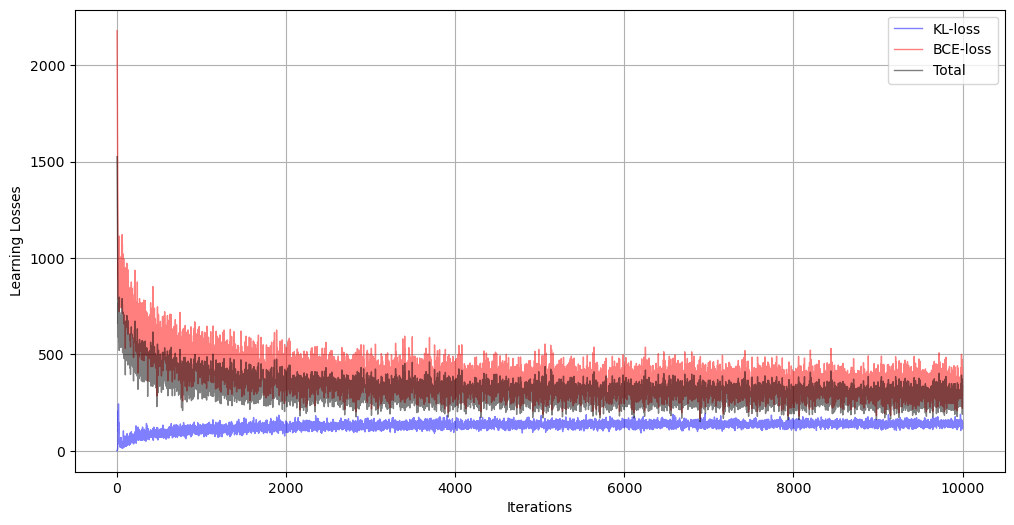

In [19]:
plt.figure(figsize=(12,6))
if weight == 0:  
    plt.plot(bce_loss_[:10000], color="red", linewidth=1,  alpha=0.5, label="BCE-loss") 
    plt.plot(total_loss_[:10000], color="black", linewidth=1,  alpha=0.5, label="Total")
elif weight == 1:

    plt.plot(kl_loss_[:10000], color="blue", linewidth=1, alpha=0.5, label="KL-loss")  
    plt.plot(total_loss_[:10000], color="black", linewidth=1,  alpha=0.5, label="Total") 
else:
        
    plt.plot(kl_loss_[:10000], color="blue", linewidth=1, alpha=0.5, label="KL-loss") 
    plt.plot(bce_loss_[:10000], color="red", linewidth=1,  alpha=0.5, label="BCE-loss") 
    plt.plot(total_loss_[:10000], color="black", linewidth=1,  alpha=0.5, label="Total") 

plt.ylabel("Learning Losses")
plt.xlabel("Iterations")
plt.grid()
plt.legend()
plt.savefig("results/learning_curve.png")

### Testing Phase

Here, we apply VAE on our testing scenarios. Since the random sampling is helping with the uniqueness of the latent representation. 

We want to test this performance by removing some of the input data by a factor of `lossy_data_ratio`. 

At default is set `lossy_data_ratio` to 0.9. 

And then, let's see how well VAE can reconstruct the digit back...? 

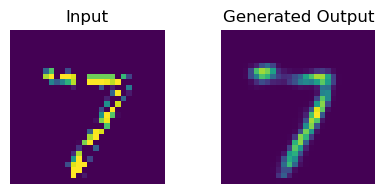

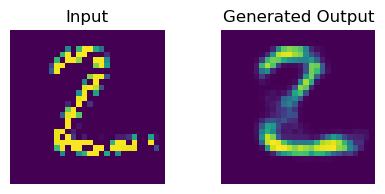

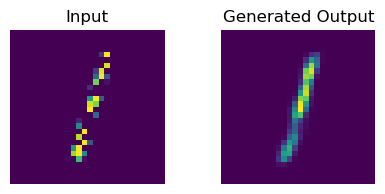

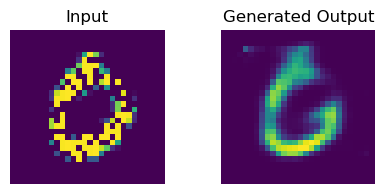

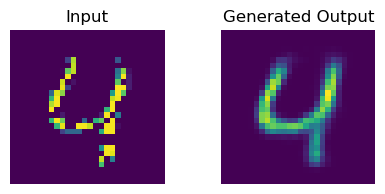

====> Test set loss: 0.0000


In [22]:
model.eval()
test_loss = 0
test_bce_loss = 0
test_kl_loss = 0

lossy_data_ratio = 0.9

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        if i < 5:
            data = data.view(-1)
            missing_xy = np.random.randint(28*28, size=int(28*28*lossy_data_ratio)) 
            data[missing_xy] = 0
            data         = data.view(1,1,28,28).to(device) 
            mu, logvar  = model.encode(data.view(-1, 784))
            z           = model.reparameterize(mu, logvar) 
            recon_batch = model.decode(z)

            test_bce_loss_, test_kl_loss_ = loss_function(recon_batch, data, mu, logvar)
            test_bce_loss += test_bce_loss_.item()
            test_kl_loss  += test_kl_loss_.item()

            intput = data.view(28, 28,1).detach().cpu().numpy()
            output = recon_batch.view(28, 28,1).detach().cpu().numpy()
            
            latent_represent = z.view(4, 5,1).detach().cpu().numpy()

            f, ax = plt.subplots(1,2, figsize=(5, 2))
            ax[0].imshow(intput)
            ax[0].set_title("Input")
            ax[0].axis('off')
            ax[1].imshow(output) 
            ax[1].axis('off')
            ax[1].set_title("Generated Output")
            plt.savefig('results/reconstruction_' + str(i) + '.png')   
            plt.show()               
            plt.close("all")

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

In [11]:
data_vect = []
label_vect_ = []
for i, (data, label) in enumerate(test_loader):
    data_vect.append(data.view(28,28).numpy())
    label_vect_.append(label.numpy()[0])

label_vect = torch.from_numpy(np.array(label_vect_))
data_vect = torch.from_numpy(np.array(data_vect)).view(10000, 1, 28, 28) 

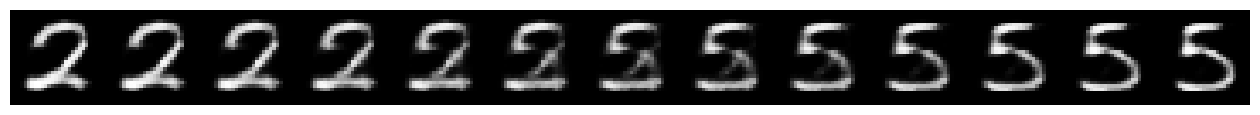

In [12]:
model.eval()

step_size = 1.0 / 12

label_vect 
class_a = 2
class_b = 5
# retriving data that corresponded to the class indices
sample_a = data_vect[label_vect == class_a][1].unsqueeze(0)
sample_b = data_vect[label_vect == class_b][1].unsqueeze(0)

# encoding both images to get sampled z values of both classes
with torch.no_grad():
    mu, logvar  = model.encode(sample_a.to(device).view(-1, 784))
    z_a         = model.reparameterize(mu, logvar) 
    

    mu, logvar  = model.encode(sample_b.to(device).view(-1, 784))
    z_b         = model.reparameterize(mu, logvar)  

# interpolation
diff = z_b - z_a
steps = torch.arange(0.0, 1.0 + step_size, step_size, 
                    dtype=torch.float, device=z_a.device).reshape(-1, 1)
zs = z_a + steps * diff

with torch.no_grad():
    out_imgs = model.decode(zs)

# flatten images
out_imgs = out_imgs.view(-1,28,28).permute(0,2,1)
out_imgs = out_imgs.detach().cpu().numpy().reshape(-1, 28).T

    

plt.figure(figsize=(16, 10))
plt.imshow(out_imgs, cmap="gray")
plt.axis("off")
plt.savefig("image_generation_%.2f_.png" % weight)
plt.show()

### How KL-Div Loss impact the encoded features ?  

We will observe the impact of the KL loss by adjusting the weights for the loss function. 

Then, we will observe the distribution of the encoded features projected onto the tsne space. 

In [13]:
from sklearn.manifold import TSNE

 
with torch.no_grad():
    mu, logvar = model.encode(data_vect.to(device).view(-1, 784))
    z_data     = model.reparameterize(mu, logvar)

z_data = z_data.cpu().numpy()

points = TSNE(n_components=2, learning_rate="auto", 
                      perplexity=70, n_iter=1000, 
                      init="pca").fit_transform(z_data)

In [14]:
color_vect = ['red', 'green', 'blue', 'magenta', 'orange', 'cyan', 'pink', 'brown', 'grey', 'lime']

uniq = np.unique(label_vect)
colormap = {}
for i in uniq:
    colormap[i] = color_vect[i]

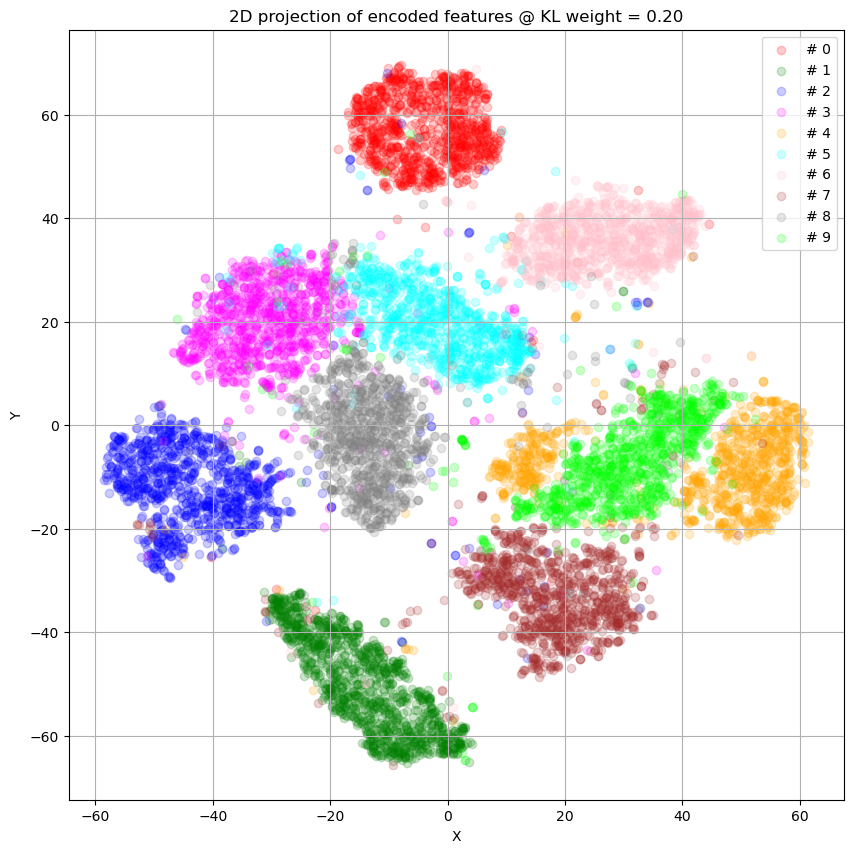

In [15]:
plt.figure(figsize=(10,10))
for i in uniq:
   plt.scatter(points[label_vect == i , 0] , points[label_vect == i , 1] , label = "# %d" % i, alpha=0.2, color = colormap[i])

plt.legend()
plt.grid('both')
plt.ylabel("Y")
plt.xlabel("X")
plt.title("2D projection of encoded features @ KL weight = %.2f" % weight)
plt.savefig("KL-weight%.2f_.png" % weight)
plt.show()